# COVID-19 X-rays Classifier tutorial 

## 1) Load the Data

COVID-19


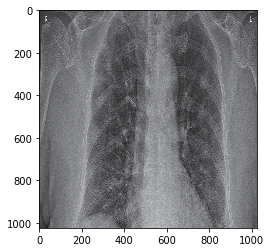

1024

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from os import walk
DATADIR = "COVID-19 Radiography Database"


f = []
for (dirpath, dirnames, filenames) in walk(DATADIR):
    f.extend(dirnames)
    break

for category in f:
    print(category)
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array) 
        plt.show() 

        break 
    break
img_array.shape[0]

The Chest X-ray data we are using divides the data into 3 folders (COVID-19,NORMAL,Viral Pneumonia)
so we read the images from every folder and give a label that represent it and also reshape the images from  1080 to 224

In [5]:
training_data = []
IMG_SIZE=224
def create_training_data():
    for category in f: 

        path = os.path.join(DATADIR,category) 
        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, category]) 
            except Exception as e: 
                pass


create_training_data()

print(len(training_data))

100%|██████████████████████████████████████████████████████████████████████████████| 1345/1345 [00:43<00:00, 31.03it/s]

2905


Shuffle the data after reading  it so the model can learn and don't overfit over one class

In [6]:
import random

random.shuffle(training_data)

In [54]:
for sample in training_data[:10]: # see a sample of the labels
    print(sample[1])

NORMAL
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
NORMAL
NORMAL
Viral Pneumonia
NORMAL


In [5]:
print(len(training_data)) # the number of images we extracted

2905


## 2) Visualize the dataset

In [7]:
def show_batch(image_batch,label_batch): # see a batch of  the  data to better understand it
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(label_batch[n])
        plt.axis("off")

In [8]:
def show_batch_predicted(image_batch): # see the same batch after prediction from the model
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        pred=model.predict(np.array(image_batch[n]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
        label=np.argmax(pred,axis=1)
        if label[0] == 0:
            plt.title('COVID-19')
        elif label[0] == 1:
            plt.title('Normal')
        elif label[0] == 2:
            plt.title('Viral Pneumonia')
        plt.axis("off")

now we prepare the data for the training by converting the images to an array and convert the labels to 3 binary code that represent the classes 

(2905, 1)
[['NORMAL']
 ['NORMAL']
 ['Viral Pneumonia']
 ...
 ['NORMAL']
 ['NORMAL']
 ['Viral Pneumonia']]
(2905, 3) (2905, 224, 224, 1)


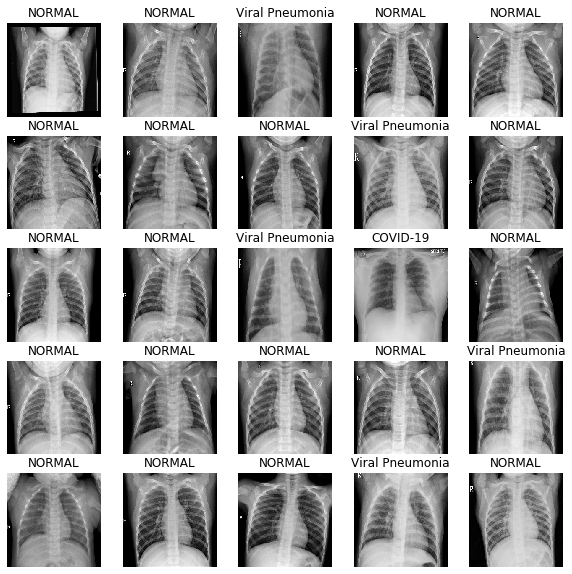

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y=np.array(y).reshape(-1, 1)
print(y.shape)
print(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y=to_categorical(y)
print(y.shape,X.shape)

## 3) Correct for data imbalance

Lets see the number of images of every class

In [9]:
counts=[]
for i in range(3):
    counts.append(y[:,i].astype(bool).sum(axis=0))
counts

[219, 1341, 1345]

now we have the problem that the classes is not balanced so the model may just predict the class that have more images without learning.
so we need to set the classes weights 

In [10]:
for i in range (3):
    counts[i] = (1 / counts[i])*(len(X))/3.0 

print(counts)
class_weight = {0: counts[0], 1: counts[1], 2: counts[2]}

[4.421613394216133, 0.7220979368630375, 0.7199504337050806]


## 4) Split the training data

now we will split the training data into train(80%) and test(20%)

In [11]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 5) Build the CNN

In [12]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D,SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D

In [13]:
def conv_block(clf,filters,kernel_size):
    clf.add(SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same'))
    clf.add(BatchNormalization(epsilon=0.001))
    clf.add(LeakyReLU(alpha=0.1))
    clf.add(SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same'))
    clf.add(BatchNormalization(epsilon=0.001))
    clf.add(LeakyReLU(alpha=0.1))
    clf.add(MaxPooling2D(pool_size=2))
    return clf

def dense_block(clf,units, dropout_rate):
    
    clf.add(Dense(units,activation='relu'))
    clf.add(BatchNormalization(epsilon=0.001))
    clf.add(Dropout(dropout_rate))
    
    return clf

In [43]:
def build_model():
    clf = Sequential()
    clf.add(Convolution2D(filters=16, kernel_size=5, padding='same', input_shape=X_train.shape[1:]))
    clf.add(Convolution2D(filters=16, kernel_size=5, padding='same'))
    clf.add(MaxPooling2D(pool_size=2))
    clf=conv_block(clf,32,5)
    clf=conv_block(clf,64,5)
    
    clf=conv_block(clf,128,5)
    clf.add(Dropout(.2))
    
    clf=conv_block(clf,256,5)
    clf.add(Dropout(.2))
    
    clf=conv_block(clf,256,5)
    clf.add(Dropout(.2))
    
    clf.add(Flatten())
    clf=dense_block(clf,2304, 0.3)
    clf=dense_block(clf,512, 0.3)
    clf=dense_block(clf,128, 0.3)
    
    clf.add(Dense(3, activation='softmax'))

    return clf
model=build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 224, 224, 16)      416       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 16)      6416      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
separable_conv2d_81 (Separab (None, 112, 112, 32)      944       
_________________________________________________________________
batch_normalization_105 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 112, 112, 32)      0         
_________________________________________________________________
separable_conv2d_82 (Separab (None, 112, 112, 32)     

## 6) Train the model

In [32]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping,LearningRateScheduler


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("Covid_model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    X_train,y_train,
    epochs=100, batch_size=32,
    validation_split=.2,verbose=1, shuffle=True,
    callbacks=[checkpoint_cb, lr_scheduler],
    class_weight=class_weight
)

Train on 1859 samples, validate on 465 samples
Epoch 1/100
1859/1859 [==============================] - 18s 10ms/step - loss: 1.1270 - accuracy: 0.5444 - val_loss: 10.6463 - val_accuracy: 0.0839
Epoch 2/100
1859/1859 [==============================] - 14s 8ms/step - loss: 0.6258 - accuracy: 0.7386 - val_loss: 10.0892 - val_accuracy: 0.0839
Epoch 3/100
1859/1859 [==============================] - 14s 8ms/step - loss: 0.4731 - accuracy: 0.8053 - val_loss: 1.3059 - val_accuracy: 0.3075
Epoch 4/100
1859/1859 [==============================] - 14s 8ms/step - loss: 0.4128 - accuracy: 0.8268 - val_loss: 2.3358 - val_accuracy: 0.1591
Epoch 5/100
1859/1859 [==============================] - 14s 8ms/step - loss: 0.3374 - accuracy: 0.8558 - val_loss: 0.6430 - val_accuracy: 0.6645
Epoch 6/100
1859/1859 [==============================] - 14s 8ms/step - loss: 0.2691 - accuracy: 0.8935 - val_loss: 6.4244 - val_accuracy: 0.4602
Epoch 7/100
1859/1859 [==============================] - 14s 8ms/step - lo

## 7) Predict and evaluate results

In [33]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

581/581 [==============================] - 1s 2ms/step
Test loss: 0.1379230151693505
Test accuracy: 95.35284042358398


In [44]:
from keras.models import load_model
model.load_weights('COVID-19_Radiography_Classifier.h5')

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

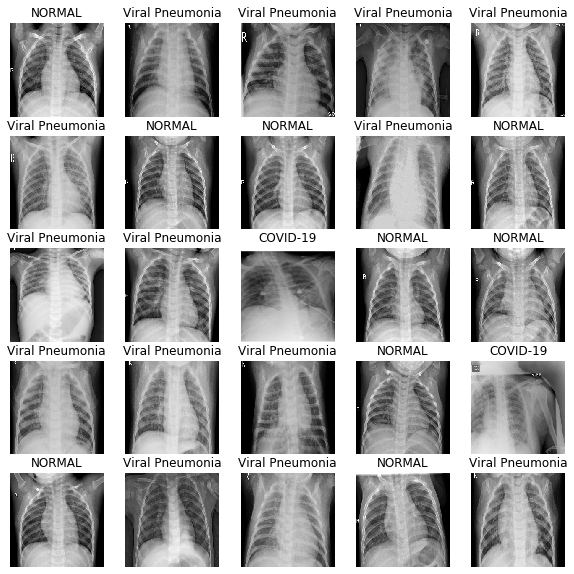

In [52]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)

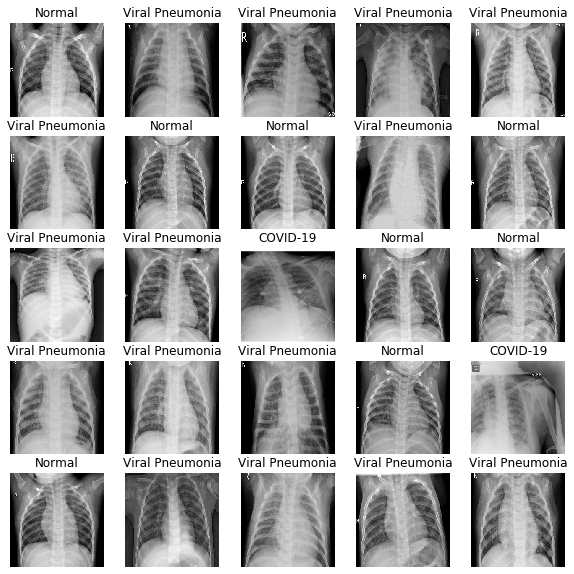

In [53]:
show_batch_predicted(X)